<a href="https://colab.research.google.com/github/b4wolf/NEURALNETS/blob/development/working_copy_PMWeather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.8 MB/s eta 0:00:00


In [36]:
import torch
import folium
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
from scipy.spatial.distance import euclidean
import os
import networkx as nx
from torch_geometric.data import Data
import math
from heapq import nsmallest
import pandas as pd
import re
import glob
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import scipy.sparse as sparse

In [26]:
import json
import os
import pandas as pd

json_folder = 'WI_weather_coords'
csv_folder = 'clean_WI_data'

weather_dict = {}

for filename in os.listdir(json_folder):
    if filename.endswith('.json'):
        with open(os.path.join(json_folder, filename), 'r') as f:
            data = json.load(f)
            prefix = filename.split('.')[0]
            weather_dict[prefix] = data['lat_lon']


json_folder = './WI_weather_coords'
csv_folder = './clean_WI_data'

weather_data_mapping = {}

for json_filename in os.listdir(json_folder):
    if json_filename.endswith('.json'):
        prefix = json_filename.split('.')[0]
        json_path = os.path.join(json_folder, json_filename)
        with open(json_path, 'r') as f:
            data = json.load(f)
            lat_lon = data['lat_lon']

            if prefix not in weather_data_mapping:
                weather_data_mapping[prefix] = {'lat_lon': None, 'csv_path': None}

            weather_data_mapping[prefix]['lat_lon'] = lat_lon

for csv_filename in os.listdir(csv_folder):
    if csv_filename.endswith('.csv'):
        prefix = csv_filename.split('.')[0]

        if prefix in weather_data_mapping:
            csv_path = os.path.join(csv_folder, csv_filename)
            weather_data_mapping[prefix]['csv_path'] = csv_path


lat_lon_mapping = {}

for json_filename in os.listdir(json_folder):
    if json_filename.endswith('.json'):
        prefix = json_filename.split('.')[0]
        json_path = os.path.join(json_folder, json_filename)
        with open(json_path, 'r') as f:
            data = json.load(f)
            lat_lon_mapping[prefix] = data['lat_lon']

weather_data = {}

for csv_filename in os.listdir(csv_folder):
    if csv_filename.endswith('.csv'):
        prefix = csv_filename.split('.')[0]

        if prefix in lat_lon_mapping:
            csv_path = os.path.join(csv_folder, csv_filename)

            df = pd.read_csv(csv_path)

            df['latitude'] = lat_lon_mapping[prefix][0]
            df['longitude'] = lat_lon_mapping[prefix][1]

            weather_data[prefix] = df


In [27]:
import regex as re
directory_path = '/content/pm_data'
file_names = [file for file in os.listdir(directory_path) if 'monitor' in file and file.endswith('.csv')]
data_frames = []

for file_name in file_names:
    match = re.match(r'processed_monitor_([0-9.-]+)_([0-9.-]+)\.csv', file_name)
    if match:
        lat, lon = match.groups()
        lat, lon = float(lat), float(lon)
        try:
            df = pd.read_csv(os.path.join(directory_path, file_name))
            df['Latitude'] = lat
            df['Longitude'] = lon
            data_frames.append(df)
        except FileNotFoundError:
            print(f"File not found: {file_name}")
        except pd.errors.EmptyDataError:
            print(f"No data in file: {file_name}")
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")
    else:
        print(f"Filename pattern mismatch: {file_name}")

In [28]:
wet_lat_lon = []
pm_lat_lon = []
for df in weather_data:
  wet_lat_lon.append((weather_data[df]['longitude'][0], weather_data[df]['latitude'][0]))

for index, df in enumerate(data_frames):
  pm_lat_lon.append((df['Latitude'][0], df['Longitude'][0]))

In [29]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = 6371 * c

    return distance

In [ ]:
#########################################
# Finds the nearest neighbors between
# weather and PM 2.5 stations
#########################################
def find_nearest_neighbors(list1, list2):
    nearest_neighbors = []

    for point1 in list1:
        min_distance = float('inf')
        nearest_neighbor = None

        for point2 in list2:
            distance = haversine(point1[0], point1[1], point2[0], point2[1])
            if distance < min_distance:
                min_distance = distance
                nearest_neighbor = point2
        nearest_neighbors.append((point1, nearest_neighbor, min_distance))

    return nearest_neighbors

list1 = pm_lat_lon
list2 = wet_lat_lon

nearest_neighbors = find_nearest_neighbors(list1, list2)

########################################################
# SHOULD ONLY BE RUN ONCE OTHERWISE WILL CREATE PROBLEMS
########################################################
for index, n in enumerate(nearest_neighbors):
  nearest_neighbors[index] = (pm_lat_lon.index(n[0]), wet_lat_lon.index(n[1]), n[2])
  data_frames[nearest_neighbors[index][0]] = pd.concat([data_frames[nearest_neighbors[index][0]], weather_data[list(weather_data.keys())[nearest_neighbors[index][1]]]], axis=1)

# cleaning the dataframe to only get the information we need
prepped_data_frames = []
for df in data_frames:
  df = df.drop('Unnamed: 0', axis=1) \
    .drop('latitude', axis=1) \
    .drop('longitude', axis=1) \
    .drop('Index', axis=1) \
    .rename(columns={'Value': 'pm25'})
  print(df.shape)
  prepped_data_frames.append(df)

In [ ]:
#########################################
# Finds edges between stations
#########################################
G = nx.Graph()
distances = {}
node_positions = {}

for i in range(len(data_frames)):
    coord1 = (prepped_data_frames[i]['Latitude'].iloc[0], prepped_data_frames[i]['Longitude'].iloc[0])
    node_positions[i] = coord1
    distances[i] = []

    for j in range(len(data_frames)):
        if i != j:
            coord2 = (prepped_data_frames[j]['Latitude'].iloc[0], prepped_data_frames[j]['Longitude'].iloc[0])
            distance = haversine(coord1[0], coord1[1], coord2[0], coord2[1])
            distances[i].append((distance, j))

for i, dist_list in distances.items():
    three_nearest = nsmallest(3, dist_list)
    for dist, j in three_nearest:
        G.add_edge(i, j, weight=dist)

plt.figure(figsize=(10, 8))
nx.draw(G, pos=node_positions, with_labels=True, node_size=50, node_color="skyblue", edge_color="gray")
plt.title("Station Graph")
plt.show()
x = nx.adjacency_matrix(G)
print(x)

(8760, 9)
<class 'torch.Tensor'> <class 'torch.Tensor'>
Epoch 0: train RMSE 54.2514, test RMSE 55.4281
Epoch 1: train RMSE 47.4706, test RMSE 48.4347
Epoch 2: train RMSE 43.6454, test RMSE 44.1393
Epoch 3: train RMSE 41.1813, test RMSE 41.1532
Epoch 4: train RMSE 39.1885, test RMSE 38.6273
Epoch 5: train RMSE 37.4550, test RMSE 36.4794
Epoch 6: train RMSE 35.9331, test RMSE 34.5942
Epoch 7: train RMSE 34.4612, test RMSE 32.8843
Epoch 8: train RMSE 33.4071, test RMSE 31.6608
Epoch 9: train RMSE 32.5067, test RMSE 30.7243


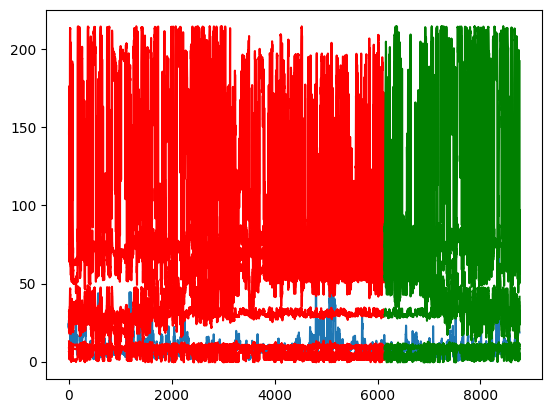

(8760, 9)
<class 'torch.Tensor'> <class 'torch.Tensor'>
Epoch 0: train RMSE 62.9749, test RMSE 62.1247
Epoch 1: train RMSE 54.2828, test RMSE 53.6648
Epoch 2: train RMSE 48.6930, test RMSE 48.0451
Epoch 3: train RMSE 44.6249, test RMSE 43.9230
Epoch 4: train RMSE 41.5131, test RMSE 40.6600
Epoch 5: train RMSE 39.0374, test RMSE 38.0420
Epoch 6: train RMSE 37.2366, test RMSE 36.0992
Epoch 7: train RMSE 35.5746, test RMSE 34.4394
Epoch 8: train RMSE 34.2831, test RMSE 33.0526
Epoch 9: train RMSE 33.2096, test RMSE 32.0061


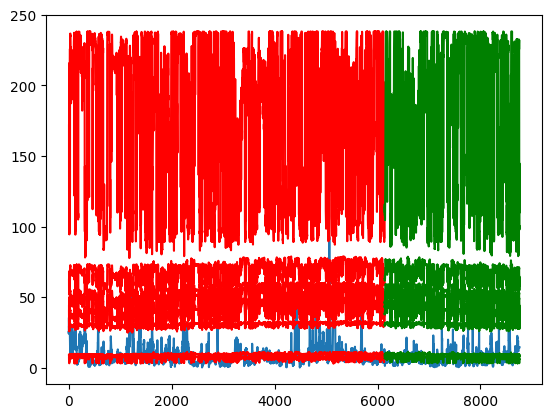

(8760, 9)
<class 'torch.Tensor'> <class 'torch.Tensor'>
Epoch 0: train RMSE 63.6003, test RMSE 65.4997
Epoch 1: train RMSE 54.7384, test RMSE 56.5617
Epoch 2: train RMSE 48.9924, test RMSE 50.3807
Epoch 3: train RMSE 44.6658, test RMSE 45.4149
Epoch 4: train RMSE 40.9623, test RMSE 41.0430
Epoch 5: train RMSE 37.5645, test RMSE 37.1152
Epoch 6: train RMSE 34.9378, test RMSE 33.9751
Epoch 7: train RMSE 32.4039, test RMSE 31.0413
Epoch 8: train RMSE 30.4582, test RMSE 28.7158
Epoch 9: train RMSE 29.0208, test RMSE 27.1201


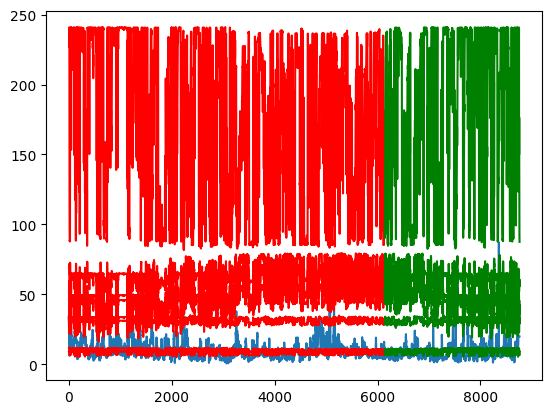

(8760, 9)
<class 'torch.Tensor'> <class 'torch.Tensor'>
Epoch 0: train RMSE 59.8805, test RMSE 59.0208
Epoch 1: train RMSE 51.3465, test RMSE 50.7179
Epoch 2: train RMSE 45.9895, test RMSE 45.3442
Epoch 3: train RMSE 42.0065, test RMSE 41.3479
Epoch 4: train RMSE 38.7042, test RMSE 38.0131
Epoch 5: train RMSE 36.0504, test RMSE 35.3002
Epoch 6: train RMSE 33.8824, test RMSE 33.1275
Epoch 7: train RMSE 32.0233, test RMSE 31.1661
Epoch 8: train RMSE 30.6582, test RMSE 29.8065
Epoch 9: train RMSE 29.4797, test RMSE 28.6628


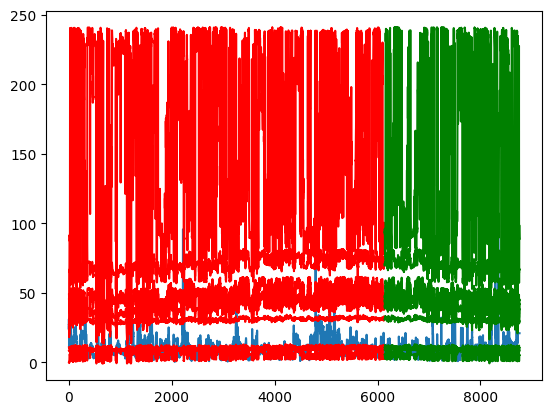

(8760, 9)
<class 'torch.Tensor'> <class 'torch.Tensor'>
Epoch 0: train RMSE 61.1262, test RMSE 64.2936
Epoch 1: train RMSE 53.1458, test RMSE 55.5209
Epoch 2: train RMSE 48.3200, test RMSE 49.5278
Epoch 3: train RMSE 44.7509, test RMSE 44.8446
Epoch 4: train RMSE 41.6886, test RMSE 40.7836
Epoch 5: train RMSE 38.9258, test RMSE 37.0954
Epoch 6: train RMSE 36.6135, test RMSE 34.0504
Epoch 7: train RMSE 34.7131, test RMSE 31.5717
Epoch 8: train RMSE 33.2361, test RMSE 29.7221
Epoch 9: train RMSE 32.0497, test RMSE 28.3099


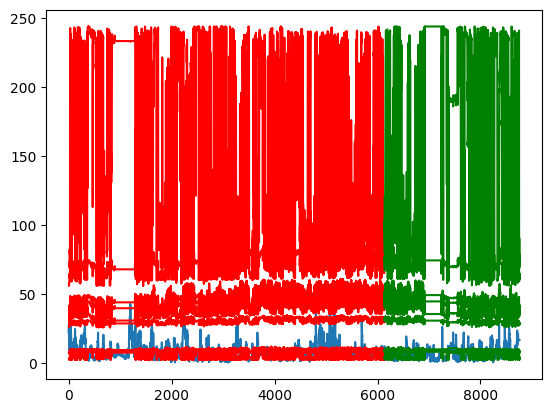

(8760, 9)
<class 'torch.Tensor'> <class 'torch.Tensor'>
Epoch 0: train RMSE 59.8588, test RMSE 59.5860
Epoch 1: train RMSE 53.0100, test RMSE 53.1908
Epoch 2: train RMSE 48.3638, test RMSE 48.3629
Epoch 3: train RMSE 44.8275, test RMSE 44.2978
Epoch 4: train RMSE 42.0515, test RMSE 41.0010
Epoch 5: train RMSE 39.7233, test RMSE 38.0234
Epoch 6: train RMSE 37.9800, test RMSE 35.7824
Epoch 7: train RMSE 36.5689, test RMSE 33.8750
Epoch 8: train RMSE 35.5573, test RMSE 32.6026
Epoch 9: train RMSE 34.6210, test RMSE 31.1977


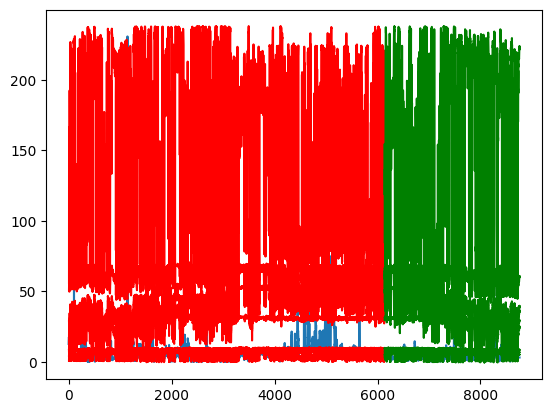

(8760, 9)
<class 'torch.Tensor'> <class 'torch.Tensor'>
Epoch 0: train RMSE 61.4822, test RMSE 61.9660
Epoch 1: train RMSE 53.4863, test RMSE 53.9660
Epoch 2: train RMSE 48.6027, test RMSE 48.7847
Epoch 3: train RMSE 45.2098, test RMSE 44.9766
Epoch 4: train RMSE 42.7100, test RMSE 41.9712
Epoch 5: train RMSE 40.8178, test RMSE 39.6345
Epoch 6: train RMSE 39.3937, test RMSE 37.8324
Epoch 7: train RMSE 38.1245, test RMSE 36.2142
Epoch 8: train RMSE 36.9513, test RMSE 34.7574
Epoch 9: train RMSE 35.8695, test RMSE 33.4550


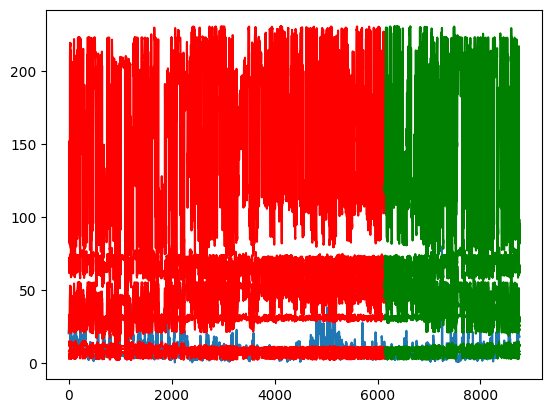

(8760, 9)
<class 'torch.Tensor'> <class 'torch.Tensor'>
Epoch 0: train RMSE 61.5756, test RMSE 60.8780
Epoch 1: train RMSE 53.2574, test RMSE 52.3166
Epoch 2: train RMSE 47.5401, test RMSE 46.0817
Epoch 3: train RMSE 43.5732, test RMSE 41.6689
Epoch 4: train RMSE 40.6104, test RMSE 38.2433
Epoch 5: train RMSE 38.3740, test RMSE 35.5415
Epoch 6: train RMSE 36.7056, test RMSE 33.5497
Epoch 7: train RMSE 35.2862, test RMSE 31.9233
Epoch 8: train RMSE 34.0930, test RMSE 30.5621
Epoch 9: train RMSE 33.1391, test RMSE 29.4301


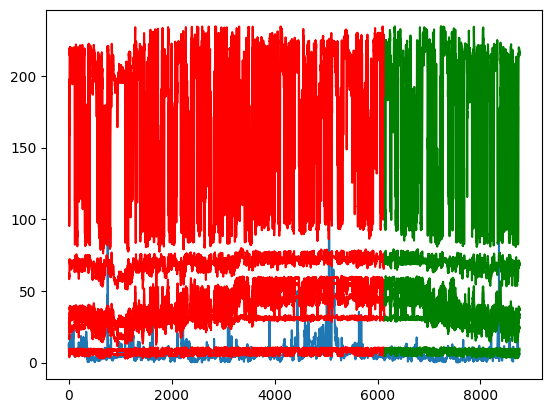

(8760, 9)
<class 'torch.Tensor'> <class 'torch.Tensor'>
Epoch 0: train RMSE 64.0563, test RMSE 63.4192
Epoch 1: train RMSE 54.9803, test RMSE 54.4404
Epoch 2: train RMSE 48.6611, test RMSE 48.0375
Epoch 3: train RMSE 43.3256, test RMSE 42.5694
Epoch 4: train RMSE 39.0652, test RMSE 38.1509
Epoch 5: train RMSE 35.6300, test RMSE 34.5461
Epoch 6: train RMSE 32.8031, test RMSE 31.5963
Epoch 7: train RMSE 30.5598, test RMSE 29.2372
Epoch 8: train RMSE 28.6307, test RMSE 27.2321
Epoch 9: train RMSE 26.9584, test RMSE 25.6661


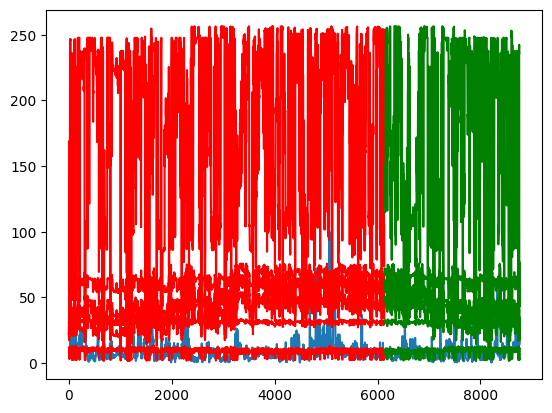

(8760, 9)
<class 'torch.Tensor'> <class 'torch.Tensor'>
Epoch 0: train RMSE 63.3056, test RMSE 65.2299
Epoch 1: train RMSE 53.6684, test RMSE 55.4519
Epoch 2: train RMSE 47.8358, test RMSE 49.0825
Epoch 3: train RMSE 43.7155, test RMSE 44.2830
Epoch 4: train RMSE 40.7250, test RMSE 40.6566
Epoch 5: train RMSE 37.8105, test RMSE 37.2300
Epoch 6: train RMSE 35.9196, test RMSE 34.8511
Epoch 7: train RMSE 34.1033, test RMSE 32.6349
Epoch 8: train RMSE 32.7471, test RMSE 30.9442
Epoch 9: train RMSE 31.6592, test RMSE 29.5838


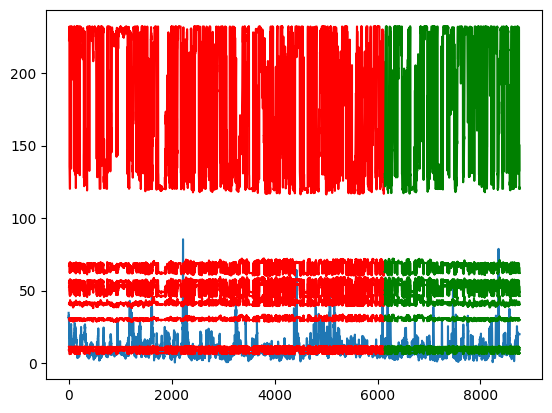

(8760, 9)
<class 'torch.Tensor'> <class 'torch.Tensor'>
Epoch 0: train RMSE 58.1963, test RMSE 59.4771
Epoch 1: train RMSE 50.6006, test RMSE 51.7171
Epoch 2: train RMSE 46.0006, test RMSE 46.6031
Epoch 3: train RMSE 42.7178, test RMSE 42.7215
Epoch 4: train RMSE 40.1117, test RMSE 39.5737
Epoch 5: train RMSE 37.9105, test RMSE 36.8275
Epoch 6: train RMSE 36.0446, test RMSE 34.5141
Epoch 7: train RMSE 34.4714, test RMSE 32.6476
Epoch 8: train RMSE 33.1510, test RMSE 30.9702
Epoch 9: train RMSE 32.1196, test RMSE 29.7183


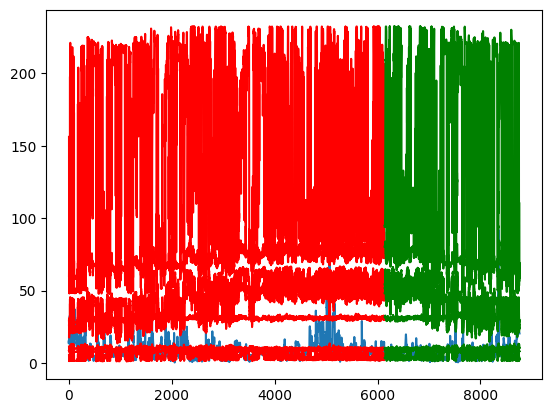

In [75]:
stat_train_predictions = []
stat_train_truths = []
stat_test_predictions = []
stat_test_truths = []

for df in prepped_data_frames:
  timeseries = df.drop('Latitude', axis=1).drop('Longitude', axis=1).values.astype('float32')
  print(timeseries.shape)
  train_size = int(len(timeseries) * 0.70)
  test_size = len(timeseries) - train_size
  train, test = timeseries[:train_size], timeseries[train_size:]
  def create_dataset(dataset, lookback):
      """Transform a time series into a prediction dataset

      Args:
          dataset: A numpy array of time series, first dimension is the time steps
          lookback: Size of window for prediction
      """
      X, y = [], []
      for i in range(len(dataset)-lookback):
          feature = dataset[i:i+lookback]
          target = dataset[i+1:i+lookback+1]
          X.append(feature)
          y.append(target)
      return torch.tensor(X), torch.tensor(y)

  lookback = 7
  X_train, y_train = create_dataset(train, lookback=lookback)
  X_test, y_test = create_dataset(test, lookback=lookback)

  stat_train_truths.append(y_train[:, -1, :].numpy())
  stat_test_truths.append(y_test[:, -1, :].numpy())

  class LSTM(nn.Module):
      def __init__(self):
          super().__init__()
          self.lstm = nn.LSTM(input_size=9, hidden_size=50, num_layers=1, batch_first=True)
          self.linear = nn.Linear(50, 9)
      def forward(self, x):
          x, _ = self.lstm(x)
          x = self.linear(x)
          return x

  model = LSTM()
  optimizer = optim.Adam(model.parameters())
  loss_fn = nn.MSELoss()
  print(type(X_train), type(y_train))
  loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

  n_epochs = 10
  for epoch in range(n_epochs):
      model.train()
      losses = []
      for X_batch, y_batch in loader:
          y_pred = model(X_batch)
          loss = loss_fn(y_pred, y_batch)
          losses.append(loss.detach().numpy())
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      # Validation
      model.eval()
      with torch.no_grad():
          y_pred = model(X_train)
          train_rmse = np.sqrt(loss_fn(y_pred, y_train))
          y_pred = model(X_test)
          test_rmse = np.sqrt(loss_fn(y_pred, y_test))
      print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

  with torch.no_grad():
    y_pred = model(X_train)
    stat_train_predictions.append(y_pred[:, -1, :])
    y_pred = model(X_test)
    stat_test_predictions.append(y_pred[:, -1, :])

  with torch.no_grad():
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]

  plt.plot(timeseries[:, 0])
  plt.plot(train_plot, c='r')
  plt.plot(test_plot, c='g')
  plt.show()

In [74]:
print(stat_train_predictions[0].shape)

torch.Size([6125, 9])


In [76]:
train_samples = []
train_truths = []
for i in range(len(stat_train_predictions[0])):
  sample = []
  for stat in stat_train_predictions:
    #print(stat[0, :].numpy())
    sample.append(stat[i, :].numpy())
  train_samples.append(sample)

for i in range(len(stat_train_truths[0])):
  truth = []
  for stat in stat_train_truths:
    #print(stat[0, :].numpy())
    truth.append(stat[i, :])
  train_truths.append(sample)

print(np.array(train_samples).shape)
print(np.array(train_truths).shape)

test_samples = []
test_truths = []
for i in range(len(stat_test_predictions[0])):
  sample = []
  for stat in stat_test_predictions:
    #print(stat[0, :].numpy())
    sample.append(stat[i, :].numpy())
  test_samples.append(sample)

for i in range(len(stat_test_truths[0])):
  truth = []
  for stat in stat_test_truths:
    #print(stat[0, :].numpy())
    truth.append(stat[i, :])
  test_truths.append(sample)

print(np.array(test_samples).shape)
print(np.array(test_truths).shape)

(6125, 11, 9)
(6125, 11, 9)
(2621, 11, 9)
(2621, 11, 9)


In [ ]:
edge_index = torch.tensor(list(G.edges())).t().contiguous()

class BasicGNN(torch.nn.Module):
    def __init__(self, num_features):
        super(BasicGNN, self).__init__()
        self.conv1 = SAGEConv(num_features, 64)
        self.conv2 = SAGEConv(64, num_features)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x.squeeze()

model = BasicGNN(num_features=9)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()



for epoch in range(2000):
    loss_values = []
    rmse_values = []
    mae_values = []
    for i, sample in enumerate(train_samples):

      x = torch.tensor(sample, dtype=torch.float)
      targets = torch.tensor(train_truths[i], dtype=torch.float)
      data = Data(x=x, edge_index=edge_index, y=targets)
      num_nodes = data.num_nodes

      train_mask = torch.zeros(num_nodes, dtype=torch.bool)
      test_mask = torch.zeros(num_nodes, dtype=torch.bool)
      train_size = int(num_nodes * 0.8)

      train_mask[:train_size] = True
      test_mask[train_size:] = True
      data.train_mask = train_mask
      data.test_mask = test_mask

      model.train()
      optimizer.zero_grad()
      out = model(data)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss_values.append(loss.item())
      loss.backward()
      optimizer.step()


    # Calculate RMSE and MAE
    with torch.no_grad():
      for i, sample in enumerate(test_samples):

        x = torch.tensor(sample, dtype=torch.float)
        targets = torch.tensor(test_truths[i], dtype=torch.float)
        data = Data(x=x, edge_index=edge_index, y=targets)
        num_nodes = data.num_nodes

        train_mask = torch.zeros(num_nodes, dtype=torch.bool)
        test_mask = torch.zeros(num_nodes, dtype=torch.bool)
        train_size = int(num_nodes * 0.8)

        train_mask[:train_size] = True
        test_mask[train_size:] = True
        data.train_mask = train_mask
        data.test_mask = test_mask

        model.eval()
        predictions = model(data)
        rmse = torch.sqrt(criterion(predictions[data.test_mask], data.y[data.test_mask]))
        mae = torch.mean(torch.abs(predictions[data.test_mask] - data.y[data.test_mask]))

        rmse_values.append(rmse.item())
        mae_values.append(mae.item())

      print(f"Epoch {epoch}, Loss: {np.mean(loss_values)}, RMSE: {np.mean(rmse_values)}, MAE: {np.mean(mae_values)}")

Epoch 0, Loss: 558.0979484489596, RMSE: 38.56399289727529, MAE: 24.7642743282762
Epoch 1, Loss: 502.9547506078603, RMSE: 18.93377694224911, MAE: 10.73773200327274
Epoch 2, Loss: 460.1206040636958, RMSE: 19.139805008190727, MAE: 10.442945359363577
Epoch 3, Loss: 436.57213790208465, RMSE: 20.82037582273749, MAE: 10.619823198198407
Epoch 4, Loss: 431.4878361791494, RMSE: 20.636186909011556, MAE: 10.726784187980574
Epoch 5, Loss: 422.5097036830357, RMSE: 18.914602936064636, MAE: 9.98349212244784
Epoch 6, Loss: 400.27386162458146, RMSE: 18.872943757372656, MAE: 10.161044965850992
Epoch 7, Loss: 403.6958841577647, RMSE: 19.23491210529978, MAE: 10.252469213442783
Epoch 8, Loss: 397.10139307387993, RMSE: 19.030519287898223, MAE: 10.212259780719325
